S1 - **Install the required libraries**

1.   yfinance - downloading the finance data
2.   pandas - for data manipulation

1.   numpy - for numerical calculations
2.   matplotlib - for data visualization







In [ ]:
pip install yfinance pandas numpy matplotlib

S2 - We will use yfinance for fetching historical stock data. Here we are going to work with Apple stock (AAPL)

In [ ]:
# Step 1: Required imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

# Step 2: Download stock data
stock_data = yf.download('AAPL', start='2023-11-01', end='2023-12-01')
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2023-11-01  172.894104  173.970001  174.229996  170.119995  171.000000   
2023-11-02  176.471832  177.570007  177.779999  175.460007  175.520004   
2023-11-03  175.557510  176.649994  176.820007  173.350006  174.240005   
2023-11-06  178.121552  179.229996  179.429993  176.210007  176.380005   
2023-11-07  180.695572  181.820007  182.440002  178.970001  179.179993   

Price         Volume  
Ticker          AAPL  
Date                  
2023-11-01  56934900  
2023-11-02  77334800  
2023-11-03  79763700  
2023-11-06  63841300  
2023-11-07  70530000  


S3 - Compute daily returns

*   Daily returns are the percentage changes in the closing prices b/w consecutive days. These will be used to assign states.



In [ ]:
# Step 3: Calculate daily returns with more granular changes
stock_data['Daily Return'] = stock_data['Close'].pct_change()
print(stock_data[['Close', 'Daily Return']].head())

Price            Close Daily Return
Ticker            AAPL             
Date                               
2023-11-01  173.970001          NaN
2023-11-02  177.570007     0.020693
2023-11-03  176.649994    -0.005181
2023-11-06  179.229996     0.014605
2023-11-07  181.820007     0.014451


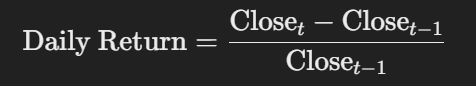

S4 - Assign states based on Daily Returns

*   Up Return > +0.1% (0.001 in decimal)
*   Down Return < -0.1% (-0.001 in decimal)


*   Stable: -0.1% <= Return <= +0.1%





In [ ]:
# Step 4: Define states with more granular boundaries
def assign_state(return_value):
    if return_value > 0.015:  # Strong up
        return 'Strong_Up'
    elif return_value > 0.005:  # Moderate up
        return 'Moderate_Up'
    elif return_value > -0.005:  # Stable
        return 'Stable'
    elif return_value > -0.015:  # Moderate down
        return 'Moderate_Down'
    else:  # Strong down
        return 'Strong_Down'

stock_data['State'] = stock_data['Daily Return'].apply(assign_state)
print(stock_data[['Close', 'Daily Return', 'State']].head(10))

Price            Close Daily Return          State
Ticker            AAPL                            
Date                                              
2023-11-01  173.970001          NaN    Strong_Down
2023-11-02  177.570007     0.020693      Strong_Up
2023-11-03  176.649994    -0.005181  Moderate_Down
2023-11-06  179.229996     0.014605    Moderate_Up
2023-11-07  181.820007     0.014451    Moderate_Up
2023-11-08  182.889999     0.005885    Moderate_Up
2023-11-09  182.410004    -0.002625         Stable
2023-11-10  186.399994     0.021874      Strong_Up
2023-11-13  184.800003    -0.008584  Moderate_Down
2023-11-14  187.440002     0.014286    Moderate_Up




*   Each day is assigned a state based on it's daily return.
*   This classification allows us to analyze transitions b/w states over time.



S5 - Create the transition matrix
We calculate the probabilites of moving from one state to another (eg. Up -> Down)

In [ ]:
# Step 5: Modified transition matrix calculation
states = stock_data['State'].dropna().tolist()
unique_states = ['Strong_Up', 'Moderate_Up', 'Stable', 'Moderate_Down', 'Strong_Down']
transition_matrix = {state: Counter() for state in unique_states}

for i in range(len(states) - 1):
    current_state = states[i]
    next_state = states[i+1]
    transition_matrix[current_state][next_state] += 1

# Smaller smoothing factor for more realistic transitions
smoothing_factor = 0.05
for state in transition_matrix:
    total = sum(transition_matrix[state].values()) + smoothing_factor * len(unique_states)
    for next_state in unique_states:
        transition_matrix[state][next_state] = (transition_matrix[state][next_state] + smoothing_factor) / total

S6 - Simulate Stock Price Movements
Using the transition matrix, we simulate the future stock pruces.

In [ ]:
# Step 6: Improved simulation function with more realistic price movements
def simulate_stock_price(start_price, days, transition_matrix):
    # Calculate historical volatility and trend
    historical_volatility = stock_data['Daily Return'].std()
    historical_trend = (stock_data['Close'].iloc[-1] / stock_data['Close'].iloc[0]) ** (1/len(stock_data)) - 1

    state = random.choice(unique_states)
    price = start_price
    simulated_prices = [price]
    simulated_dates = [stock_data.index[-1]]

    # Keep track of recent movements to add momentum
    recent_returns = []

    for _ in range(days):
        # Add momentum effect
        momentum = np.mean(recent_returns[-5:]) if recent_returns else 0

        # Choose next state based on transition probabilities
        next_state = random.choices(
            unique_states,
            weights=[transition_matrix[state][s] for s in unique_states],
            k=1
        )[0]

        # Define return ranges based on state (smaller ranges)
        if next_state == 'Strong_Up':
            daily_return = np.random.uniform(0.008, 0.015)
        elif next_state == 'Moderate_Up':
            daily_return = np.random.uniform(0.003, 0.008)
        elif next_state == 'Stable':
            daily_return = np.random.uniform(-0.003, 0.003)
        elif next_state == 'Moderate_Down':
            daily_return = np.random.uniform(-0.008, -0.003)
        else:  # Strong_Down
            daily_return = np.random.uniform(-0.015, -0.008)

        # Add historical trend bias
        daily_return += historical_trend / 252  # Approximate trading days in a year

        # Add momentum effect (weighted)
        daily_return += momentum * 0.3

        # Add noise based on historical volatility (reduced impact)
        noise = np.random.normal(0, historical_volatility/3)
        daily_return += noise

        # Update price
        price *= (1 + daily_return)
        simulated_prices.append(price)

        # Update tracking variables
        recent_returns.append(daily_return)
        if len(recent_returns) > 5:
            recent_returns.pop(0)

        next_date = simulated_dates[-1] + pd.Timedelta(days=1)
        simulated_dates.append(next_date)
        state = next_state

    return simulated_dates, simulated_prices

S7 - Visualize the prices

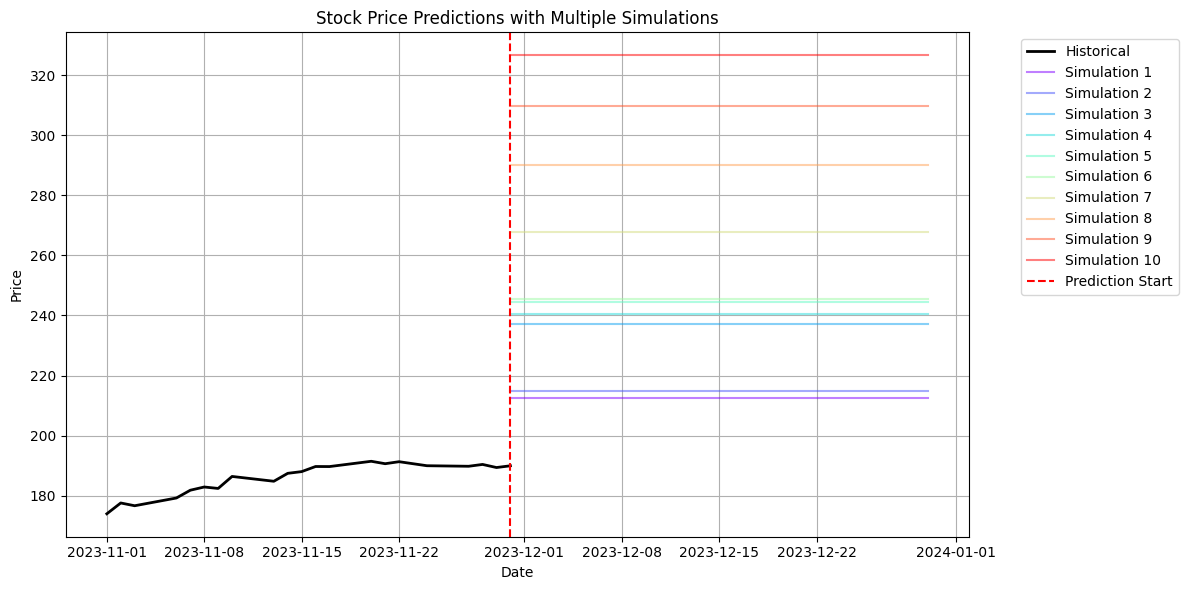

In [ ]:
# Step 7: Plot remains the same as previous version, but with these parameters:
start_price = stock_data['Close'].iloc[-1]
num_simulations = 10

plt.figure(figsize=(12, 6))

# Plot historical data
historical_dates = stock_data.index
historical_prices = stock_data['Close']
plt.plot(historical_dates, historical_prices, label='Historical', color='black', linewidth=2)

# Plot multiple simulations
colors = plt.cm.rainbow(np.linspace(0, 1, num_simulations))
for i in range(num_simulations):
    simulated_dates, simulated_prices = simulate_stock_price(start_price, 30, transition_matrix)
    plt.plot(simulated_dates, simulated_prices, label=f'Simulation {i+1}', alpha=0.5, color=colors[i])

plt.axvline(x=simulated_dates[0], color='r', linestyle='--', label='Prediction Start')
plt.title('Stock Price Predictions with Multiple Simulations')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Calculating accuracy

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ValueError: Found array with dim 3. None expected <= 2.

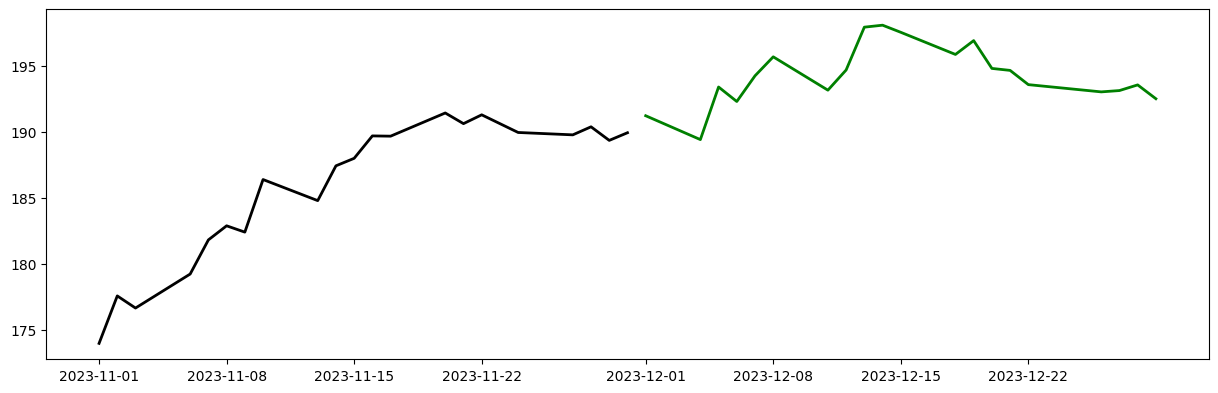

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from datetime import datetime, timedelta

# Download training and testing data
end_date = '2023-12-01'
test_end_date = '2024-01-01'  # One month ahead for testing

# Get training data
stock_data_train = yf.download('AAPL', start='2023-11-01', end=end_date)
# Get test data for accuracy comparison
stock_data_test = yf.download('AAPL', start=end_date, end=test_end_date)

# Calculate daily returns for training data
stock_data_train['Daily Return'] = stock_data_train['Close'].pct_change()

# State assignment function
def assign_state(return_value):
    if return_value > 0.015:
        return 'Strong_Up'
    elif return_value > 0.005:
        return 'Moderate_Up'
    elif return_value > -0.005:
        return 'Stable'
    elif return_value > -0.015:
        return 'Moderate_Down'
    else:
        return 'Strong_Down'

# Assign states to training data
stock_data_train['State'] = stock_data_train['Daily Return'].apply(assign_state)

# Create transition matrix
states = stock_data_train['State'].dropna().tolist()
unique_states = ['Strong_Up', 'Moderate_Up', 'Stable', 'Moderate_Down', 'Strong_Down']
transition_matrix = {state: Counter() for state in unique_states}

for i in range(len(states) - 1):
    current_state = states[i]
    next_state = states[i+1]
    transition_matrix[current_state][next_state] += 1

smoothing_factor = 0.05
for state in transition_matrix:
    total = sum(transition_matrix[state].values()) + smoothing_factor * len(unique_states)
    for next_state in unique_states:
        transition_matrix[state][next_state] = (transition_matrix[state][next_state] + smoothing_factor) / total

def simulate_stock_price(start_price, days, transition_matrix):
    historical_volatility = stock_data_train['Daily Return'].std()
    historical_trend = (stock_data_train['Close'].iloc[-1] / stock_data_train['Close'].iloc[0]) ** (1/len(stock_data_train)) - 1

    state = random.choice(unique_states)
    price = start_price
    simulated_prices = [price]
    simulated_dates = [stock_data_train.index[-1]]
    recent_returns = []

    for _ in range(days):
        momentum = np.mean(recent_returns[-5:]) if recent_returns else 0

        next_state = random.choices(
            unique_states,
            weights=[transition_matrix[state][s] for s in unique_states],
            k=1
        )[0]

        if next_state == 'Strong_Up':
            daily_return = np.random.uniform(0.008, 0.015)
        elif next_state == 'Moderate_Up':
            daily_return = np.random.uniform(0.003, 0.008)
        elif next_state == 'Stable':
            daily_return = np.random.uniform(-0.003, 0.003)
        elif next_state == 'Moderate_Down':
            daily_return = np.random.uniform(-0.008, -0.003)
        else:
            daily_return = np.random.uniform(-0.015, -0.008)

        daily_return += historical_trend / 252
        daily_return += momentum * 0.3
        noise = np.random.normal(0, historical_volatility/3)
        daily_return += noise

        price *= (1 + daily_return)
        simulated_prices.append(price)

        recent_returns.append(daily_return)
        if len(recent_returns) > 5:
            recent_returns.pop(0)

        next_date = simulated_dates[-1] + pd.Timedelta(days=1)
        simulated_dates.append(next_date)
        state = next_state

    return simulated_dates, simulated_prices

# Function to calculate prediction accuracy
def calculate_accuracy(simulated_prices, actual_prices):
    # Align the dates and prices
    min_len = min(len(simulated_prices), len(actual_prices))
    sim_prices = simulated_prices[:min_len]
    act_prices = actual_prices[:min_len]

    # Calculate various error metrics
    mape = mean_absolute_percentage_error([act_prices], [sim_prices]) * 100
    rmse = np.sqrt(mean_squared_error(act_prices, sim_prices))

    # Calculate direction accuracy (up/down movement)
    sim_direction = np.diff(sim_prices) > 0
    act_direction = np.diff(act_prices) > 0
    direction_accuracy = np.mean(sim_direction == act_direction) * 100

    return mape, rmse, direction_accuracy

# Run multiple simulations and calculate accuracy
start_price = stock_data_train['Close'].iloc[-1]
num_simulations = 10
prediction_days = len(stock_data_test)

# Store results
all_simulated_prices = []
accuracy_metrics = []

# Plot setup
plt.figure(figsize=(15, 10))

# Plot historical data
plt.subplot(2, 1, 1)
plt.plot(stock_data_train.index, stock_data_train['Close'], label='Historical', color='black', linewidth=2)
plt.plot(stock_data_test.index, stock_data_test['Close'], label='Actual Future', color='green', linewidth=2)

# Run simulations and calculate accuracy
colors = plt.cm.rainbow(np.linspace(0, 1, num_simulations))
for i in range(num_simulations):
    simulated_dates, simulated_prices = simulate_stock_price(start_price, prediction_days, transition_matrix)
    all_simulated_prices.append(simulated_prices)

    # Calculate accuracy metrics
    mape, rmse, dir_acc = calculate_accuracy(simulated_prices, stock_data_test['Close'].values)
    accuracy_metrics.append({
        'Simulation': i+1,
        'MAPE': mape,
        'RMSE': rmse,
        'Direction Accuracy': dir_acc
    })

    # Plot simulation
    plt.plot(simulated_dates, simulated_prices, label=f'Simulation {i+1}', alpha=0.5, color=colors[i])

plt.axvline(x=simulated_dates[0], color='r', linestyle='--', label='Prediction Start')
plt.title('Stock Price Predictions with Multiple Simulations')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot accuracy metrics
plt.subplot(2, 1, 2)
accuracy_df = pd.DataFrame(accuracy_metrics)
accuracy_df.set_index('Simulation').plot(kind='bar', ax=plt.gca())
plt.title('Prediction Accuracy Metrics')
plt.xlabel('Simulation')
plt.ylabel('Error/Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print average accuracy metrics
print("\nAverage Accuracy Metrics:")
avg_metrics = accuracy_df.mean()
print(f"Mean Absolute Percentage Error (MAPE): {avg_metrics['MAPE']:.2f}%")
print(f"Root Mean Square Error (RMSE): ${avg_metrics['RMSE']:.2f}")
print(f"Direction Accuracy: {avg_metrics['Direction Accuracy']:.2f}%")

# Calculate ensemble prediction
ensemble_prediction = np.mean(all_simulated_prices, axis=0)
ensemble_mape, ensemble_rmse, ensemble_dir_acc = calculate_accuracy(
    ensemble_prediction,
    stock_data_test['Close'].values
)

print("\nEnsemble Model Accuracy:")
print(f"MAPE: {ensemble_mape:.2f}%")
print(f"RMSE: ${ensemble_rmse:.2f}")
print(f"Direction Accuracy: {ensemble_dir_acc:.2f}%")